# Montar Drive + Imports

In [1]:
!pip install scikit-posthocs

In [2]:
import os
from google.colab import drive
from typing import Dict, Any, List, Union
import pandas as pd
from tqdm import tqdm
import numpy as np
import networkx as nx
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, f_oneway, ttest_ind, mannwhitneyu, kruskal
from itertools import combinations
from typing import List, Union, Optional
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

In [3]:
# 1. Montar Google Drive
print("Paso 1: Montando Google Drive...")
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Máster - Data Science/TFM/Data/ESTUDIO_MULTIPLEX')

Paso 1: Montando Google Drive...
Mounted at /content/drive


# Joineos

In [4]:
def unir_csv_columnas_diferentes(
    ruta_csv1: str,
    ruta_csv2: str,
    columna_join1: Union[str, List[str]], # Columna del primer CSV (ej: 'id')
    columna_join2: Optional[Union[str, List[str]]] = None, # Columna del segundo CSV (ej: 'ids')
    tipo_join: str = 'inner'
) -> pd.DataFrame:
    """
    Carga dos archivos CSV y los une (join) en base a columnas que pueden tener nombres diferentes.

    Args:
        ruta_csv1 (str): Ruta completa al primer archivo CSV.
        ruta_csv2 (str): Ruta completa al segundo archivo CSV.
        columna_join1 (Union[str, List[str]]): El nombre de la columna(s) del PRIMER DataFrame.
        columna_join2 (Optional[Union[str, List[str]]]): El nombre de la columna(s) del SEGUNDO DataFrame.
            Si es None, se usa el valor de columna_join1 (comportamiento original).
        tipo_join (str): El tipo de join ('inner', 'left', 'right', 'outer'). Por defecto es 'inner'.

    Returns:
        pd.DataFrame: Un nuevo DataFrame que es el resultado de la unión.
            Devuelve None si ocurre un error.
    """
    try:
        # 1. Cargar los DataFrames
        df1 = pd.read_csv(ruta_csv1)
        df2 = pd.read_csv(ruta_csv2)

        # 2. Determinar las claves para la unión
        # Si columna_join2 no se proporciona, pandas usa 'on' y espera que la columna se llame igual.
        # Si sí se proporciona, usamos 'left_on' y 'right_on'.
        if columna_join2 is None or columna_join1 == columna_join2:
            join_params = {'on': columna_join1}
            clave_usada = columna_join1
        else:
            join_params = {
                'left_on': columna_join1, # Clave en df1
                'right_on': columna_join2 # Clave en df2
            }
            clave_usada = f"{columna_join1} y {columna_join2}"

        # 3. Realizar la operación de unión (join)
        df_unido = pd.merge(
            left=df1,
            right=df2,
            how=tipo_join, # Tipo de join
            **join_params  # Parámetros 'on' o 'left_on'/'right_on'
        )

        print(f"✅ Archivos unidos exitosamente usando claves: {clave_usada} ({tipo_join} join)")
        return df_unido

    except FileNotFoundError:
        print("❌ Error: Uno o ambos archivos CSV no fueron encontrados.")
        return None
    except Exception as e:
        print(f"❌ Ocurrió un error inesperado (revisa que las columnas existan): {e}")
        return None

In [5]:
multi_global_metrics = unir_csv_columnas_diferentes(
    "METRICAS_GRAFO/MULTI_GLOBAL.csv",
    "DADES_CORRECTED/CLINIC.csv",
    'id',
    'ids'
)
GM_global_metrics = unir_csv_columnas_diferentes(
    "METRICAS_GRAFO/GM_GLOBAL.csv",
    "DADES_CORRECTED/CLINIC.csv",
    'id',
    'ids'
)
FA_global_metrics = unir_csv_columnas_diferentes(
    "METRICAS_GRAFO/FA_GLOBAL.csv",
    "DADES_CORRECTED/CLINIC.csv",
    'id',
    'ids'
)
rsfMRI_global_metrics = unir_csv_columnas_diferentes(
    "METRICAS_GRAFO/rsfMRI_GLOBAL.csv",
    "DADES_CORRECTED/CLINIC.csv",
    'id',
    'ids'
)

✅ Archivos unidos exitosamente usando claves: id y ids (inner join)
✅ Archivos unidos exitosamente usando claves: id y ids (inner join)
✅ Archivos unidos exitosamente usando claves: id y ids (inner join)
✅ Archivos unidos exitosamente usando claves: id y ids (inner join)


# Visualizaciones

In [6]:
def graficar_por_grupos_subplots(df, col_x, col_y_list, encoding_dict=None, order_dict=None, palette_name='viridis'):
    """
    Genera boxplots en subgráficos, uno para cada columna en col_y_list,
    aplicando un encoding, un orden personalizado y una paleta de colores a las categorías del eje X.

    Parámetros:
    df (pd.DataFrame): DataFrame con los datos.
    col_x (str): Columna que define los grupos (eje X).
    col_y_list (list): Lista de columnas numéricas a graficar (eje Y).
    encoding_dict (dict): Diccionario para mapear los valores originales a nuevas etiquetas de col_x.
    order_dict (dict): Diccionario que define el orden de las etiquetas de col_x.
    palette_name (str): Nombre de la paleta de colores de Seaborn o Matplotlib a usar.
                        Por defecto es 'viridis'.
    """

    # --- Validaciones (sin cambios) ---
    if col_x not in df.columns:
        raise ValueError(f"La columna '{col_x}' no existe en el DataFrame.")

    for col_y in col_y_list:
        if col_y not in df.columns:
            raise ValueError(f"La columna '{col_y}' no existe en el DataFrame.")
        if not pd.api.types.is_numeric_dtype(df[col_y]):
            raise TypeError(f"La columna '{col_y}' debe ser numérica.")

    # --- Preparación del DataFrame y Orden (sin cambios) ---
    df_plot = df.copy()

    # Aplicar encoding a col_x si se proporciona
    if encoding_dict is not None:
        df_plot[col_x] = df_plot[col_x].map(encoding_dict).astype(str)
    else:
        df_plot[col_x] = df_plot[col_x].astype(str)

    # Determinar orden si se proporciona
    order = None
    if order_dict is not None:
        order = sorted(order_dict.keys(), key=lambda k: order_dict[k])

    # --- Configuración de Paleta ---
    # Contar el número de grupos en el eje X para asegurar que la paleta tenga suficientes colores
    n_grupos = len(df_plot[col_x].unique())
    try:
        # Intenta crear la paleta con el número exacto de colores
        palette = sns.color_palette(palette_name, n_colors=n_grupos)
    except ValueError:
        # Si la paleta no admite el número de colores (ej. 'Greys'), usa el nombre directamente
        palette = palette_name

    # --- Configuración de Subplots (sin cambios significativos) ---
    n_plots = len(col_y_list)
    n_cols = min(4, n_plots)
    n_rows = int(np.ceil(n_plots / n_cols))

    fig_width = 6 * n_cols
    fig_height = 5 * n_rows

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(fig_width, fig_height),
                             squeeze=False)

    axes_flat = axes.flatten()[:n_plots]

    # --- Generación de Gráficos (MODIFICACIÓN CLAVE) ---
    for i, col_y in enumerate(col_y_list):
        ax = axes_flat[i]

        # Generar el boxplot usando la PALETA definida
        sns.boxplot(
          data=df_plot,
          x=col_x,
          y=col_y,
          order=order,
          ax=ax,
          palette=palette,
          # Añadir los dos parámetros requeridos:
          hue=col_x,
          legend=False
      )

        #ax.set_title(f"{col_y} por grupos de {col_x}", fontsize=14)
        ax.set_xlabel(col_x, fontsize=12)
        ax.set_ylabel(col_y, fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis="y", linestyle="--", alpha=0.5)

    # Eliminar subgráficos vacíos
    for j in range(n_plots, n_rows * n_cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

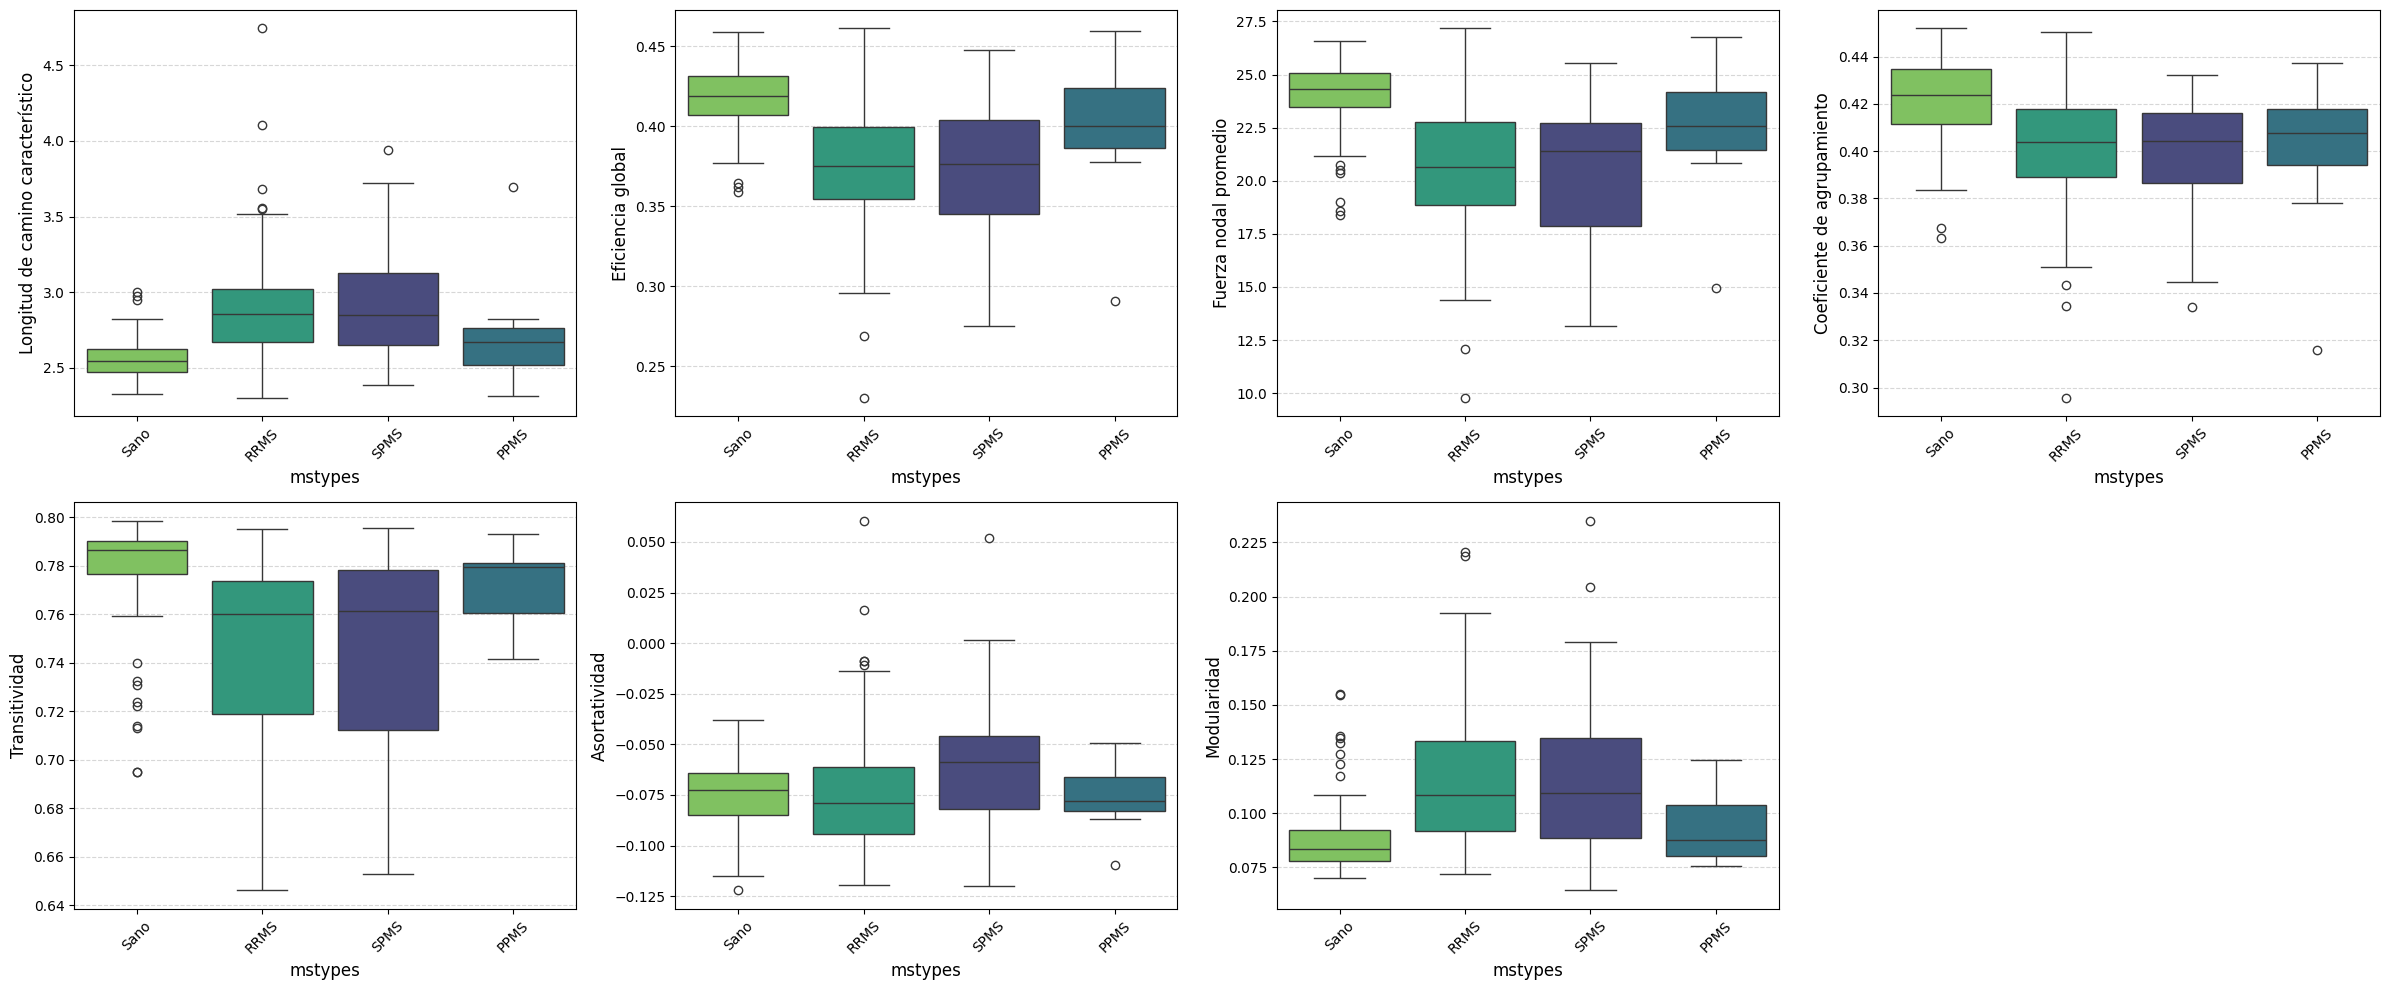

In [7]:
encoding_dict = {
    -1:"Sano",
    0: "RRMS",
    1: "SPMS",
    2: "PPMS"
}

order_dict = {
    "Sano":1,
    "RRMS":2,
    "SPMS":3,
    "PPMS":4
}

graficar_por_grupos_subplots(FA_global_metrics, "mstypes", ['Longitud de camino característico', 'Eficiencia global',
       'Fuerza nodal promedio', 'Coeficiente de agrupamiento', 'Transitividad',
       'Asortatividad', 'Modularidad'], encoding_dict, order_dict)

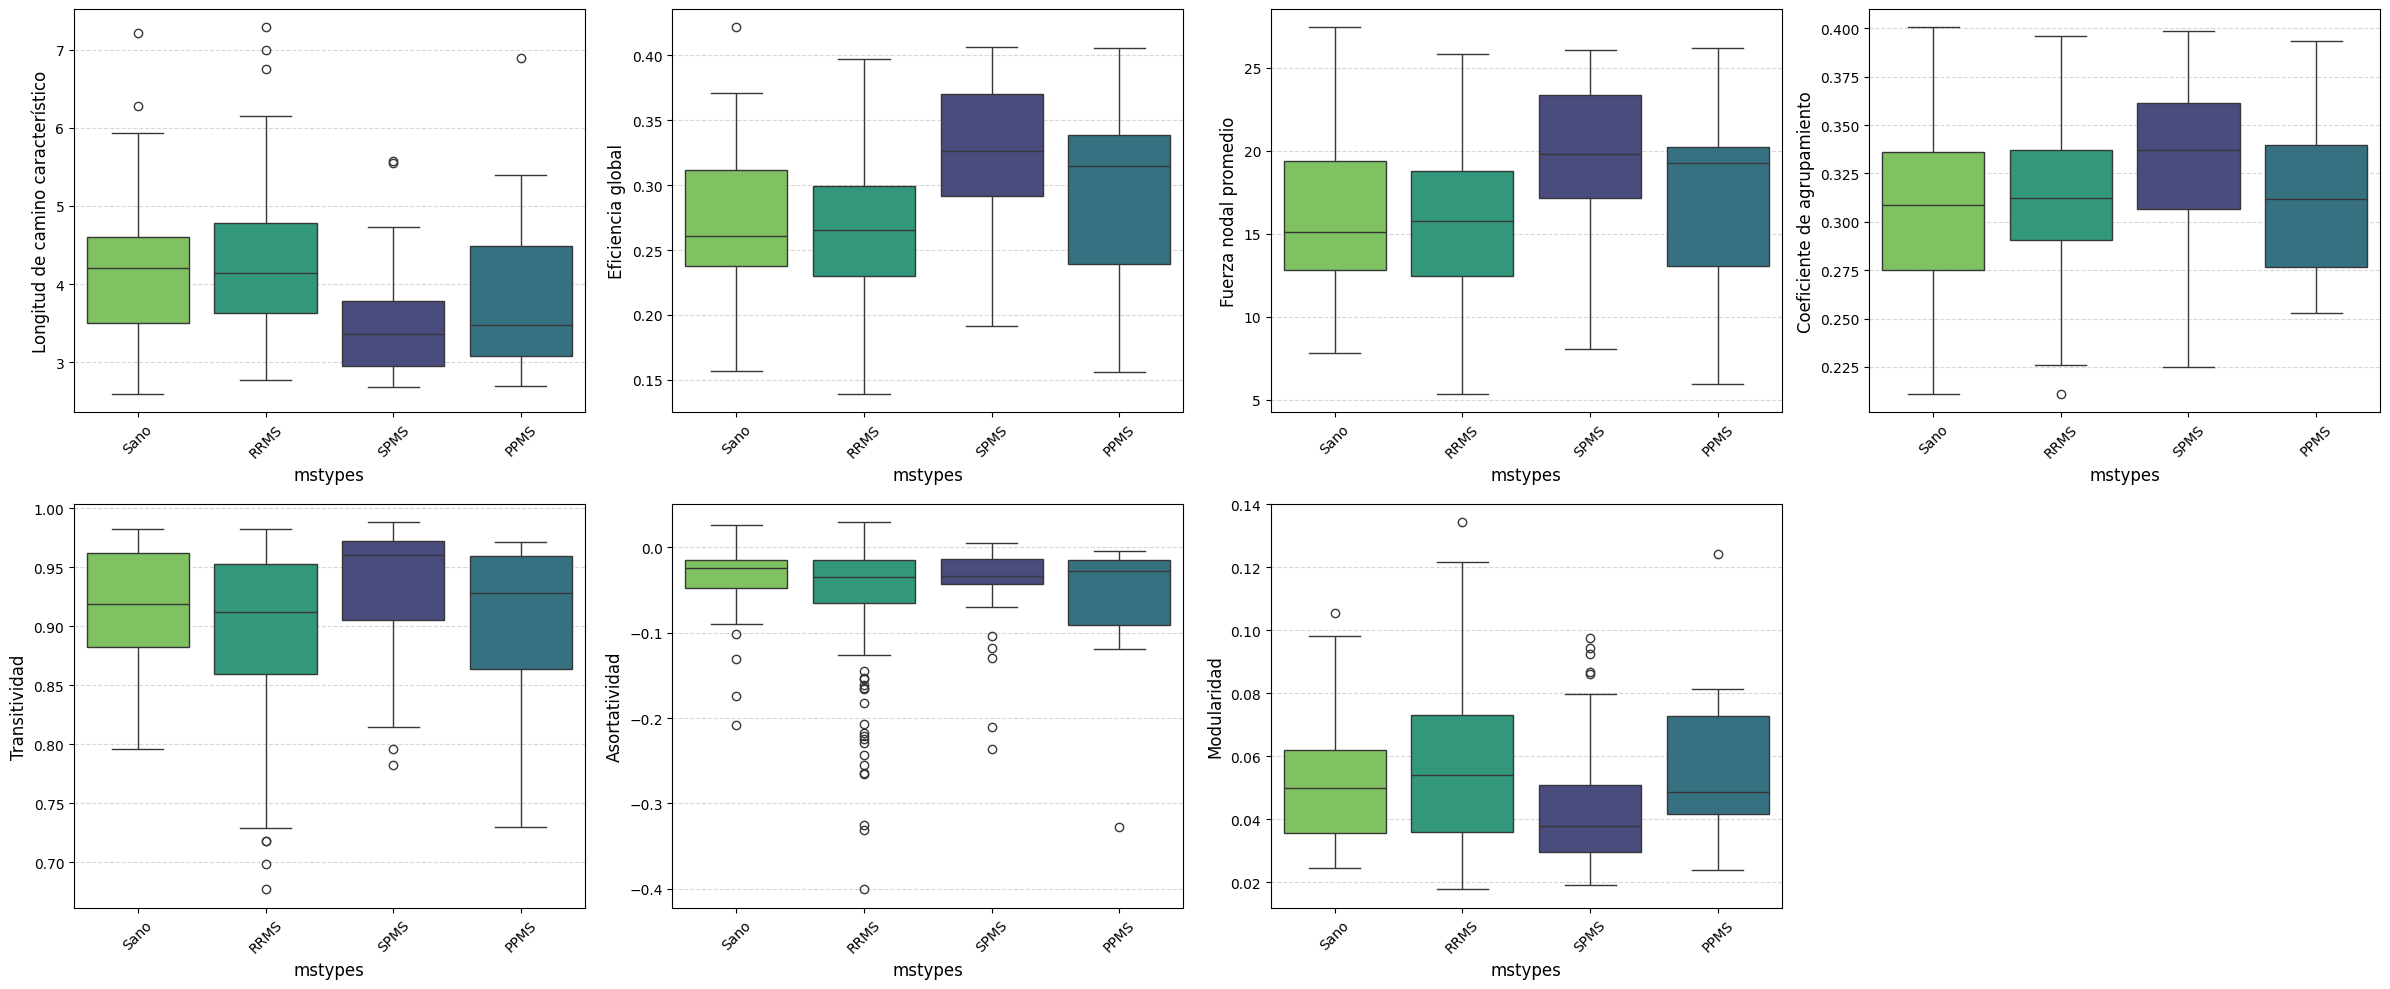

In [8]:
graficar_por_grupos_subplots(GM_global_metrics, "mstypes", ['Longitud de camino característico', 'Eficiencia global',
       'Fuerza nodal promedio', 'Coeficiente de agrupamiento', 'Transitividad',
       'Asortatividad', 'Modularidad'], encoding_dict, order_dict)

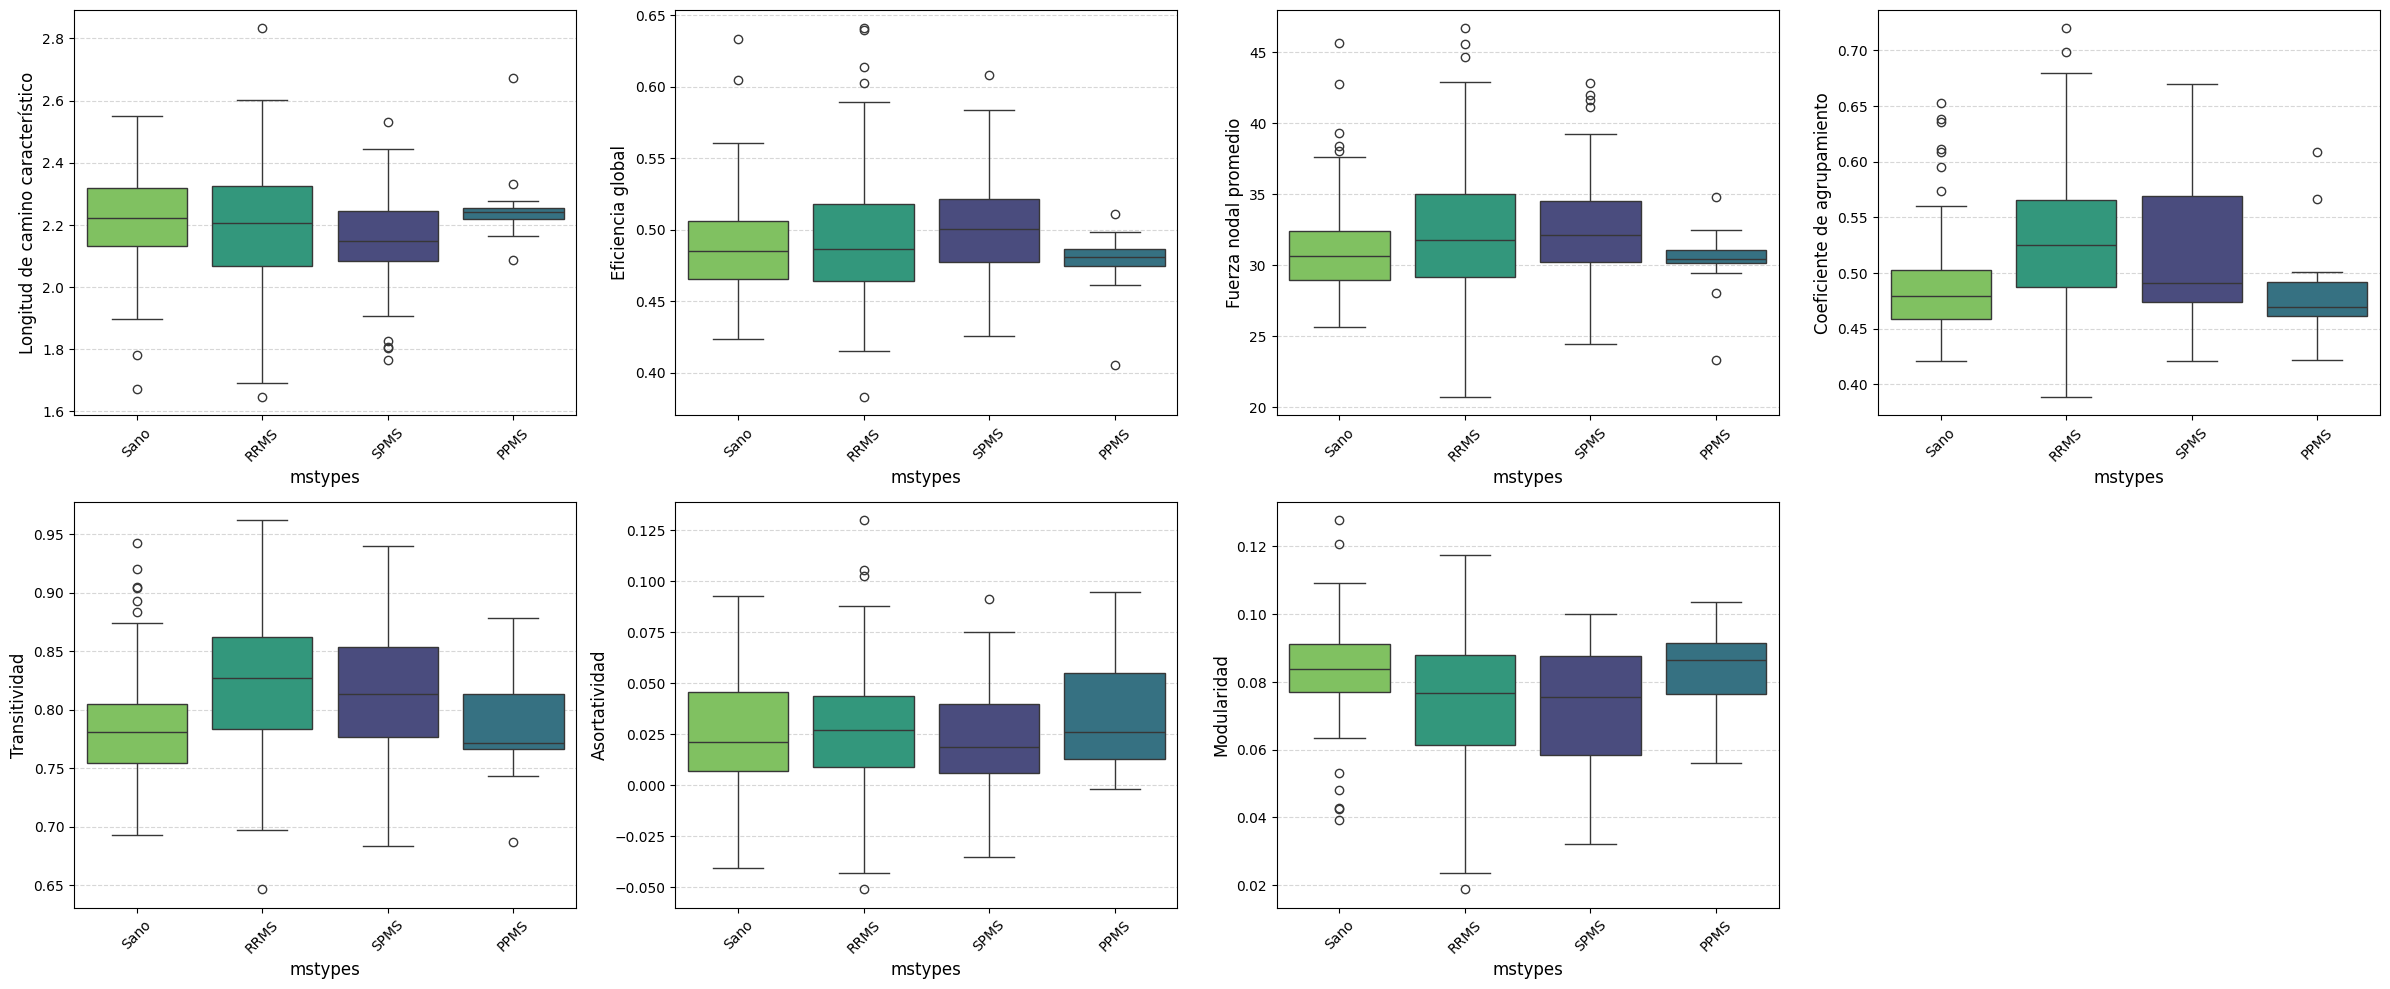

In [9]:
graficar_por_grupos_subplots(rsfMRI_global_metrics, "mstypes", ['Longitud de camino característico', 'Eficiencia global',
       'Fuerza nodal promedio', 'Coeficiente de agrupamiento', 'Transitividad',
       'Asortatividad', 'Modularidad'], encoding_dict, order_dict)

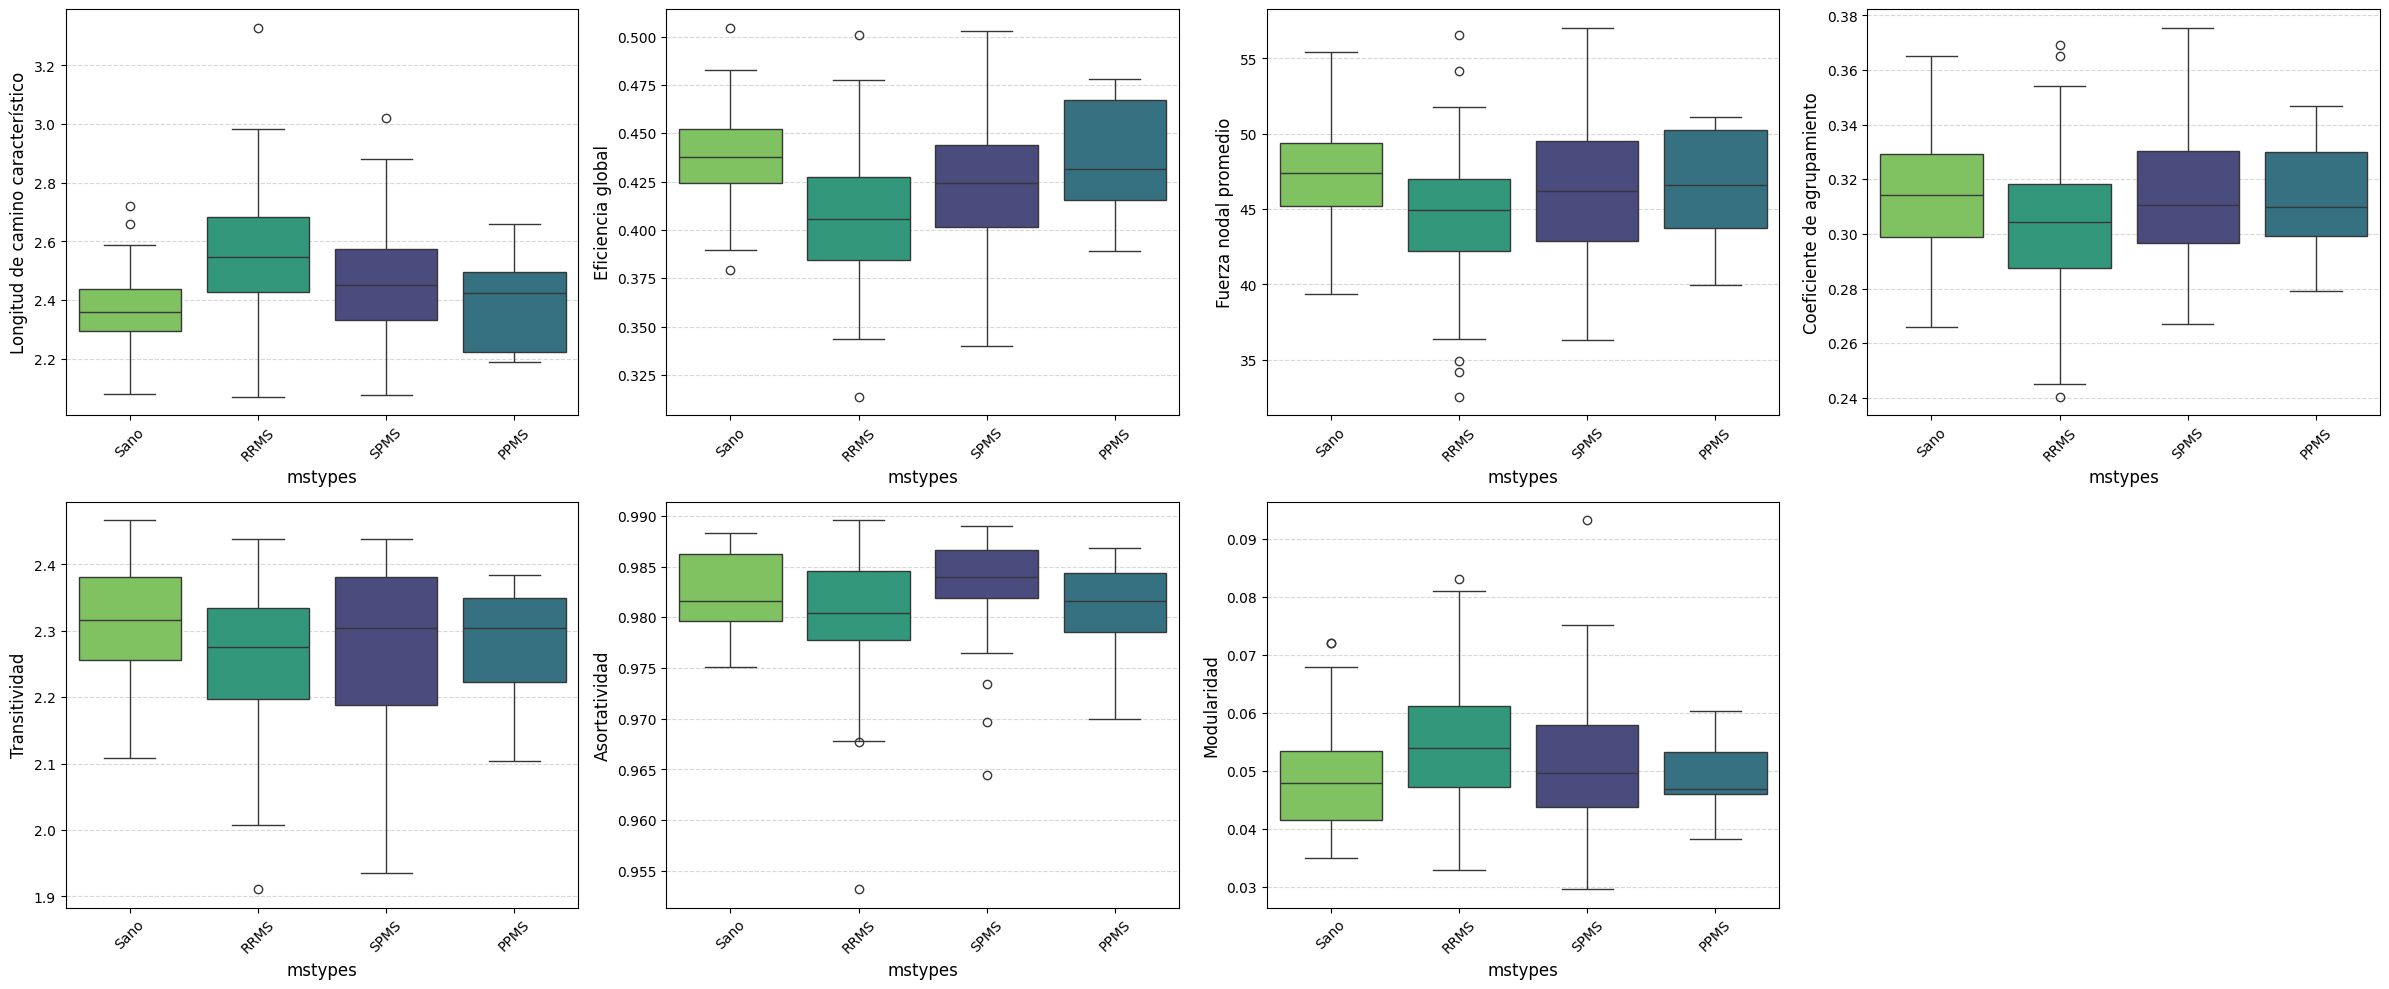

In [10]:
graficar_por_grupos_subplots(multi_global_metrics, "mstypes", ['Longitud de camino característico', 'Eficiencia global',
       'Fuerza nodal promedio', 'Coeficiente de agrupamiento', 'Transitividad',
       'Asortatividad', 'Modularidad'], encoding_dict, order_dict)

# Matriz de diferencias con p-value rojo

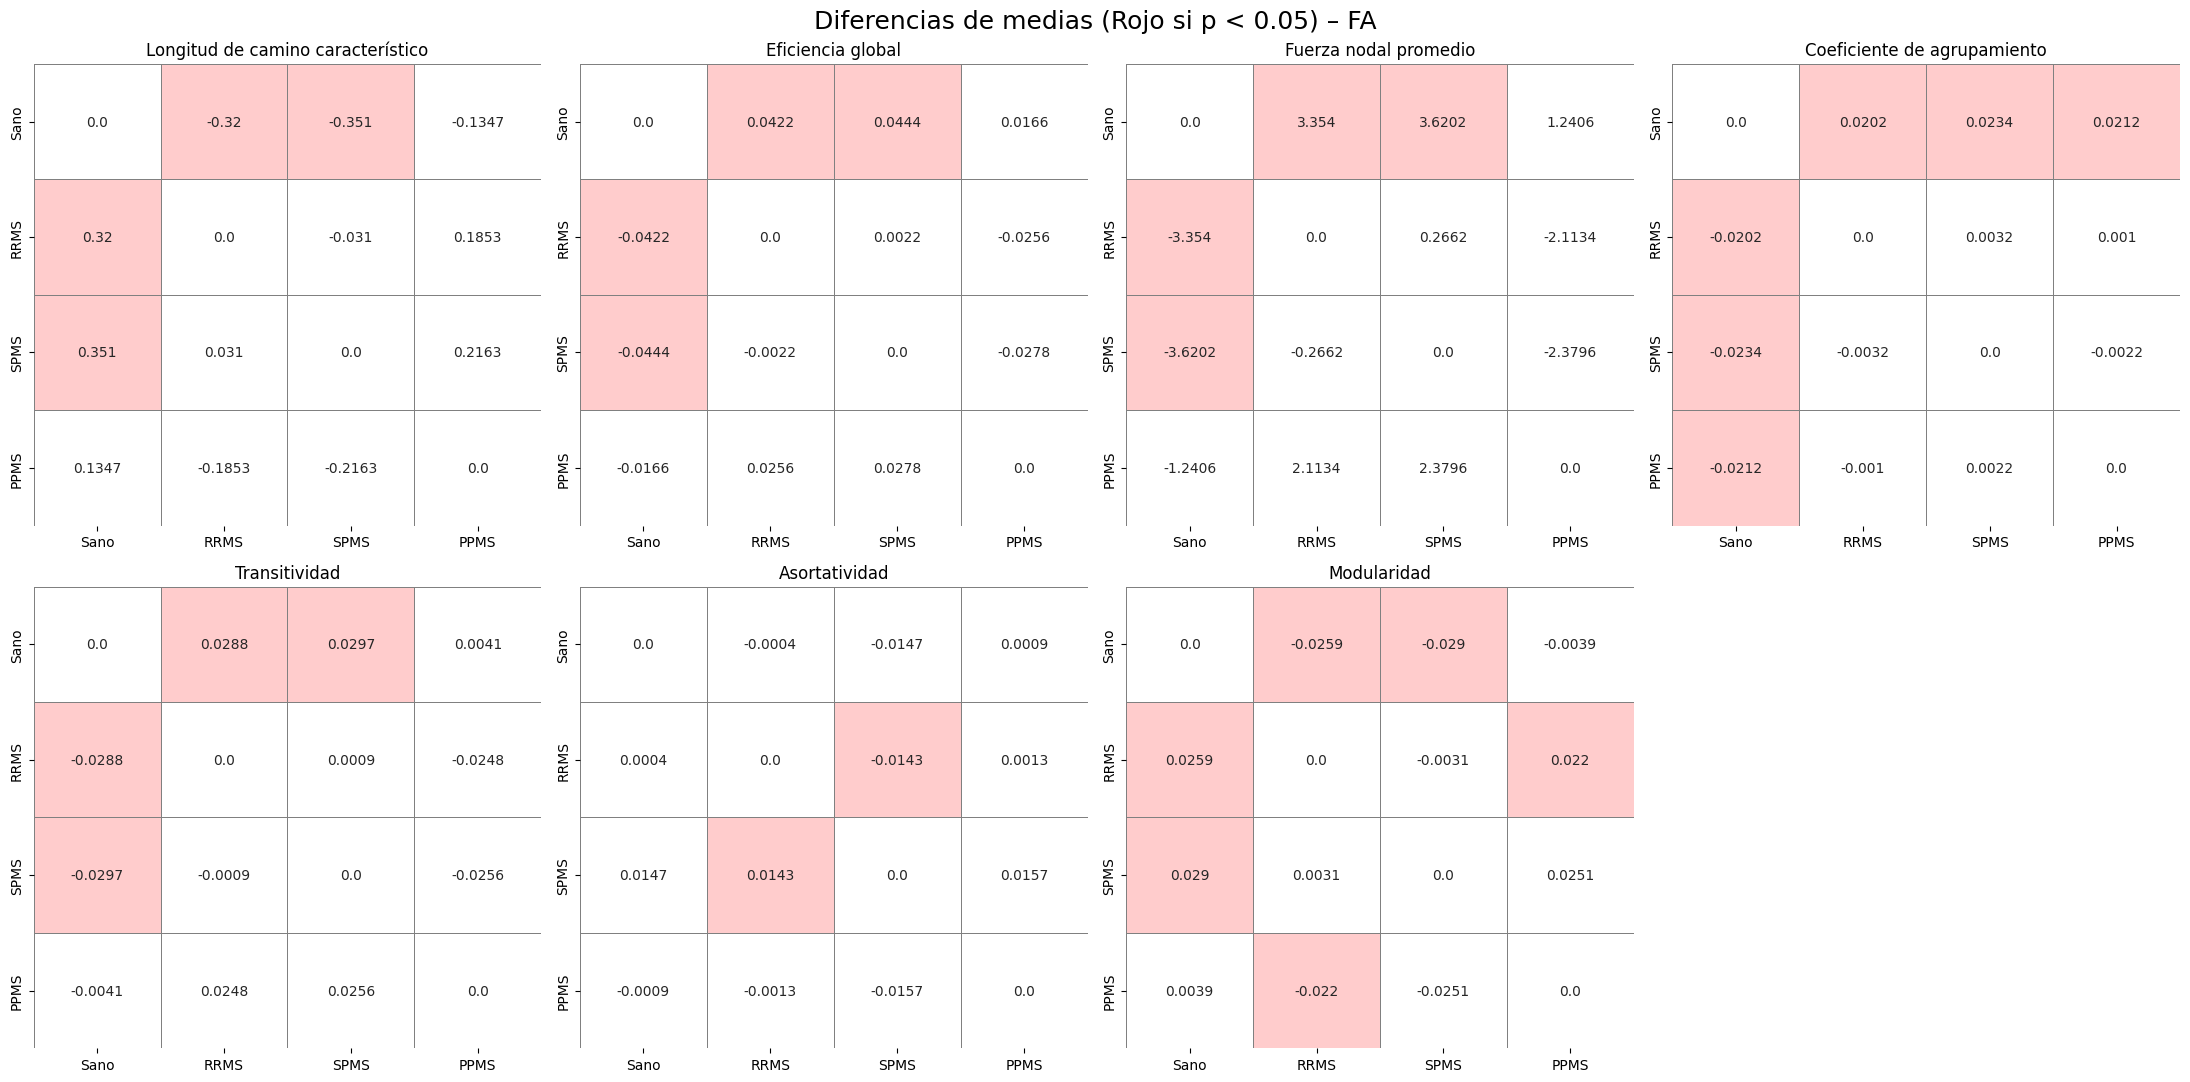

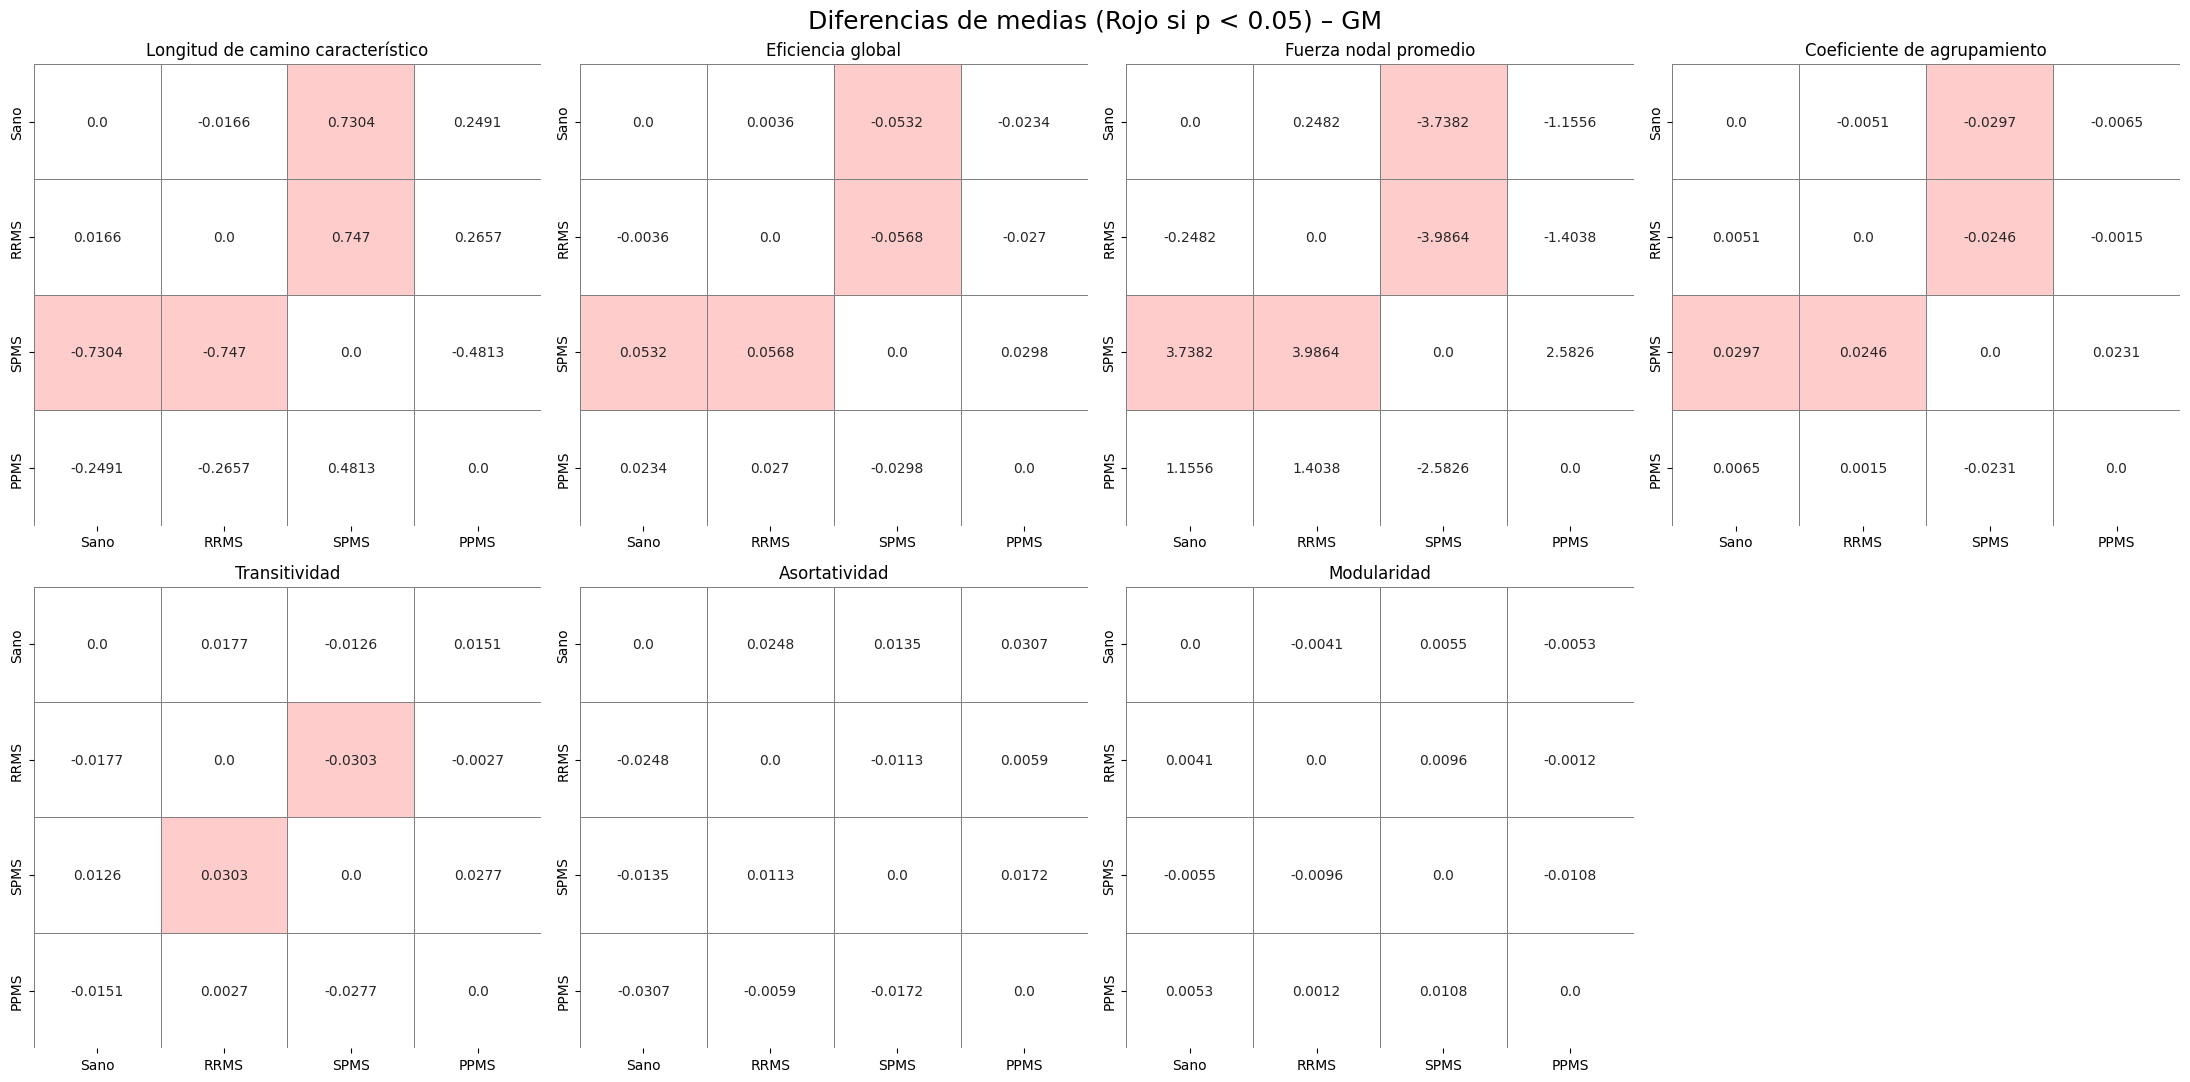

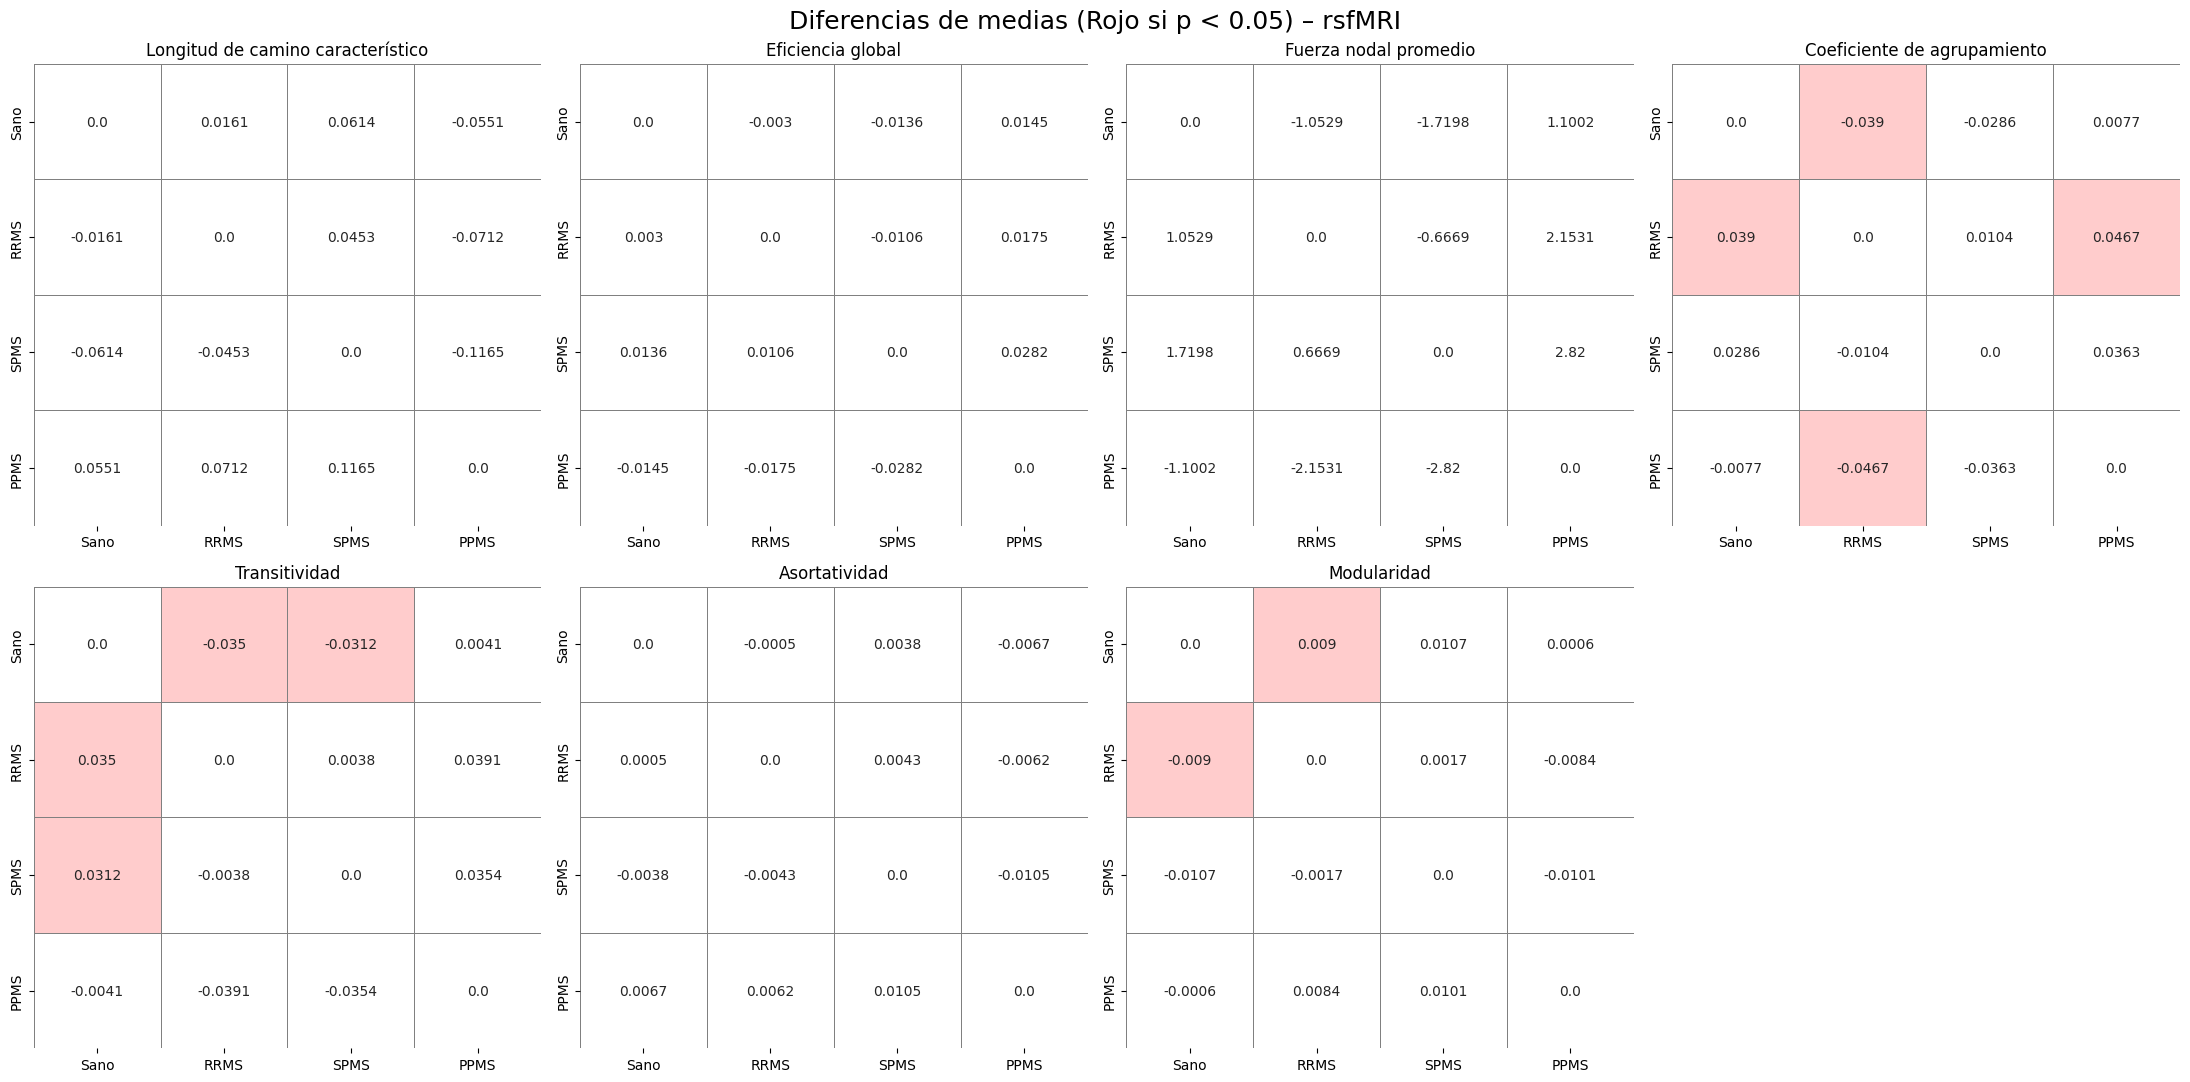

In [11]:
def analizar_diferencias_con_pares(df, num_var, cat_var):
    """
    Evalúa diferencias inter-grupo entre una variable categórica y una numérica.
    Incluye comparación global (ANOVA o Kruskal-Wallis) y comparaciones múltiples.
    """

    # --- 1. Filtrar y preparar ---
    data = df[[num_var, cat_var]].dropna()
    categorias = data[cat_var].unique()
    grupos = [data[data[cat_var] == c][num_var] for c in categorias]

    # --- 2. Normalidad por grupo ---
    normalidad_grupos = []
    for g in grupos:
        if len(g) >= 3:
            p = stats.shapiro(g)[1]
            normalidad_grupos.append(p > 0.05)
        else:
            normalidad_grupos.append(False)

    cumple_normalidad = all(normalidad_grupos)

    # --- 3. Homogeneidad de varianzas ---
    lev_p = stats.levene(*grupos)[1]
    cumple_homocedasticidad = lev_p > 0.05

    # --- 4. Prueba global ---
    if cumple_normalidad and cumple_homocedasticidad:
        test_global = "ANOVA"
        stat, pvalue = stats.f_oneway(*grupos)

        # --- Comparaciones múltiples: Tukey ---
        tukey = pairwise_tukeyhsd(
            data[num_var],
            data[cat_var],
            alpha=0.05
        )
        tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
        grupos_unicos = np.sort(pd.concat([tukey_df['group1'], tukey_df['group2']]).unique())

        pval_matrix = pd.DataFrame(np.ones((len(grupos_unicos), len(grupos_unicos))),
                                   index=grupos_unicos, columns=grupos_unicos)

        for _, row in tukey_df.iterrows():
            g1, g2, pval = row['group1'], row['group2'], row['p-adj']
            pval_matrix.loc[g1, g2] = pval
            pval_matrix.loc[g2, g1] = pval

        comparaciones = pval_matrix
    else:
        test_global = "Kruskal-Wallis"
        stat, pvalue = stats.kruskal(*grupos)

        # --- Comparaciones múltiples: Dunn con Bonferroni ---
        comparaciones = sp.posthoc_dunn(
            data,
            val_col=num_var,
            group_col=cat_var,
            p_adjust='bonferroni'
        )

    # --- NUEVO: Calcular Matriz de Diferencias de Medias ---
    # Usamos el índice de 'comparaciones' para asegurar que el orden sea idéntico
    indices_grupos = comparaciones.index
    medias = data.groupby(cat_var)[num_var].mean()

    diff_matrix = pd.DataFrame(index=indices_grupos, columns=indices_grupos, dtype=float)

    for g1 in indices_grupos:
        for g2 in indices_grupos:
            # Calculamos Media(Fila) - Media(Columna)
            val = medias[g1] - medias[g2]
            diff_matrix.loc[g1, g2] = val

    # --- 5. Conclusión ---
    conclusion = (
        "Existen diferencias significativas entre los grupos."
        if pvalue < 0.05 else
        "No se encontraron diferencias significativas entre los grupos."
    )

    # --- 6. Resultados ---
    return {
        "test_global": test_global,
        "estadístico_global": stat,
        "p_value_global": pvalue,
        "normalidad_por_grupo": normalidad_grupos,
        "homocedasticidad": cumple_homocedasticidad,
        "comparaciones_pares": comparaciones,   # Matriz de P-values
        "diferencias_medias": diff_matrix,      # NUEVO: Matriz de diferencias
        "conclusion": conclusion
    }

labels_dict = {-1: "Sano", 0: "RRMS", 1: "SPMS", 2: "PPMS"}

def get_significance_matrix(result_dict):
    # 1. Recuperar P-values para determinar el color
    p_vals = result_dict["comparaciones_pares"].copy()

    # 2. Recuperar Diferencias para el texto
    diffs = result_dict["diferencias_medias"].copy()

    alpha = 0.05
    # Matriz booleana: True si es significativo (Rojo), False si no (Blanco)
    signif_matrix = p_vals < alpha

    # Aplicar etiquetas a ambas matrices
    new_labels = [labels_dict.get(i, i) for i in p_vals.index]

    p_vals.index = new_labels
    p_vals.columns = new_labels

    diffs.index = new_labels
    diffs.columns = new_labels

    signif_matrix.index = new_labels
    signif_matrix.columns = new_labels

    return diffs, signif_matrix


def plot_all_metrics_for_global(global_metric_results, metric_names, global_metric_name):

    fig, axes = plt.subplots(2, 4, figsize=(22, 11))
    axes = axes.flatten()

    for idx, (result_dict, metric_name) in enumerate(zip(global_metric_results, metric_names)):

        # Obtenemos las diferencias (numeros) y la significancia (bool color)
        diffs, signif_matrix = get_significance_matrix(result_dict)

        ax = axes[idx]
        sns.heatmap(
            signif_matrix,             # Controla el color (0=blanco, 1=rojo)
            annot=diffs.round(4),      # Muestra la diferencia de medias
            fmt="",                    # Formato vacío porque ya pasamos floats redondeados
            cmap=["white", "#FFCCCC"], # False -> White, True -> Rojo claro
            cbar=False,
            linewidths=.5,
            linecolor='gray',
            ax=ax
        )
        ax.set_title(metric_name)

    # Subplots sobrantes
    for j in range(len(metric_names), 8):
        fig.delaxes(axes[j])

    fig.suptitle(f"Diferencias de medias (Rojo si p < 0.05) – {global_metric_name}", fontsize=18)
    plt.tight_layout()
    plt.show()


metrica_grafo = ['Longitud de camino característico', 'Eficiencia global',
       'Fuerza nodal promedio', 'Coeficiente de agrupamiento', 'Transitividad',
       'Asortatividad', 'Modularidad']
global_metrics = [FA_global_metrics, GM_global_metrics, rsfMRI_global_metrics]

for global_metric_i, global_metric_name in zip(
        global_metrics,
        ["FA", "GM", "rsfMRI"]):  # ajusta los nombres si quieres

    # Ejecutar análisis para las 7 métricas del grafo
    results = []
    for metrica_grafo_i in metrica_grafo:
        result = analizar_diferencias_con_pares(global_metric_i, metrica_grafo_i, "mstypes")
        results.append(result)

    # Generar figura 2x4
    plot_all_metrics_for_global(results, metrica_grafo, global_metric_name)

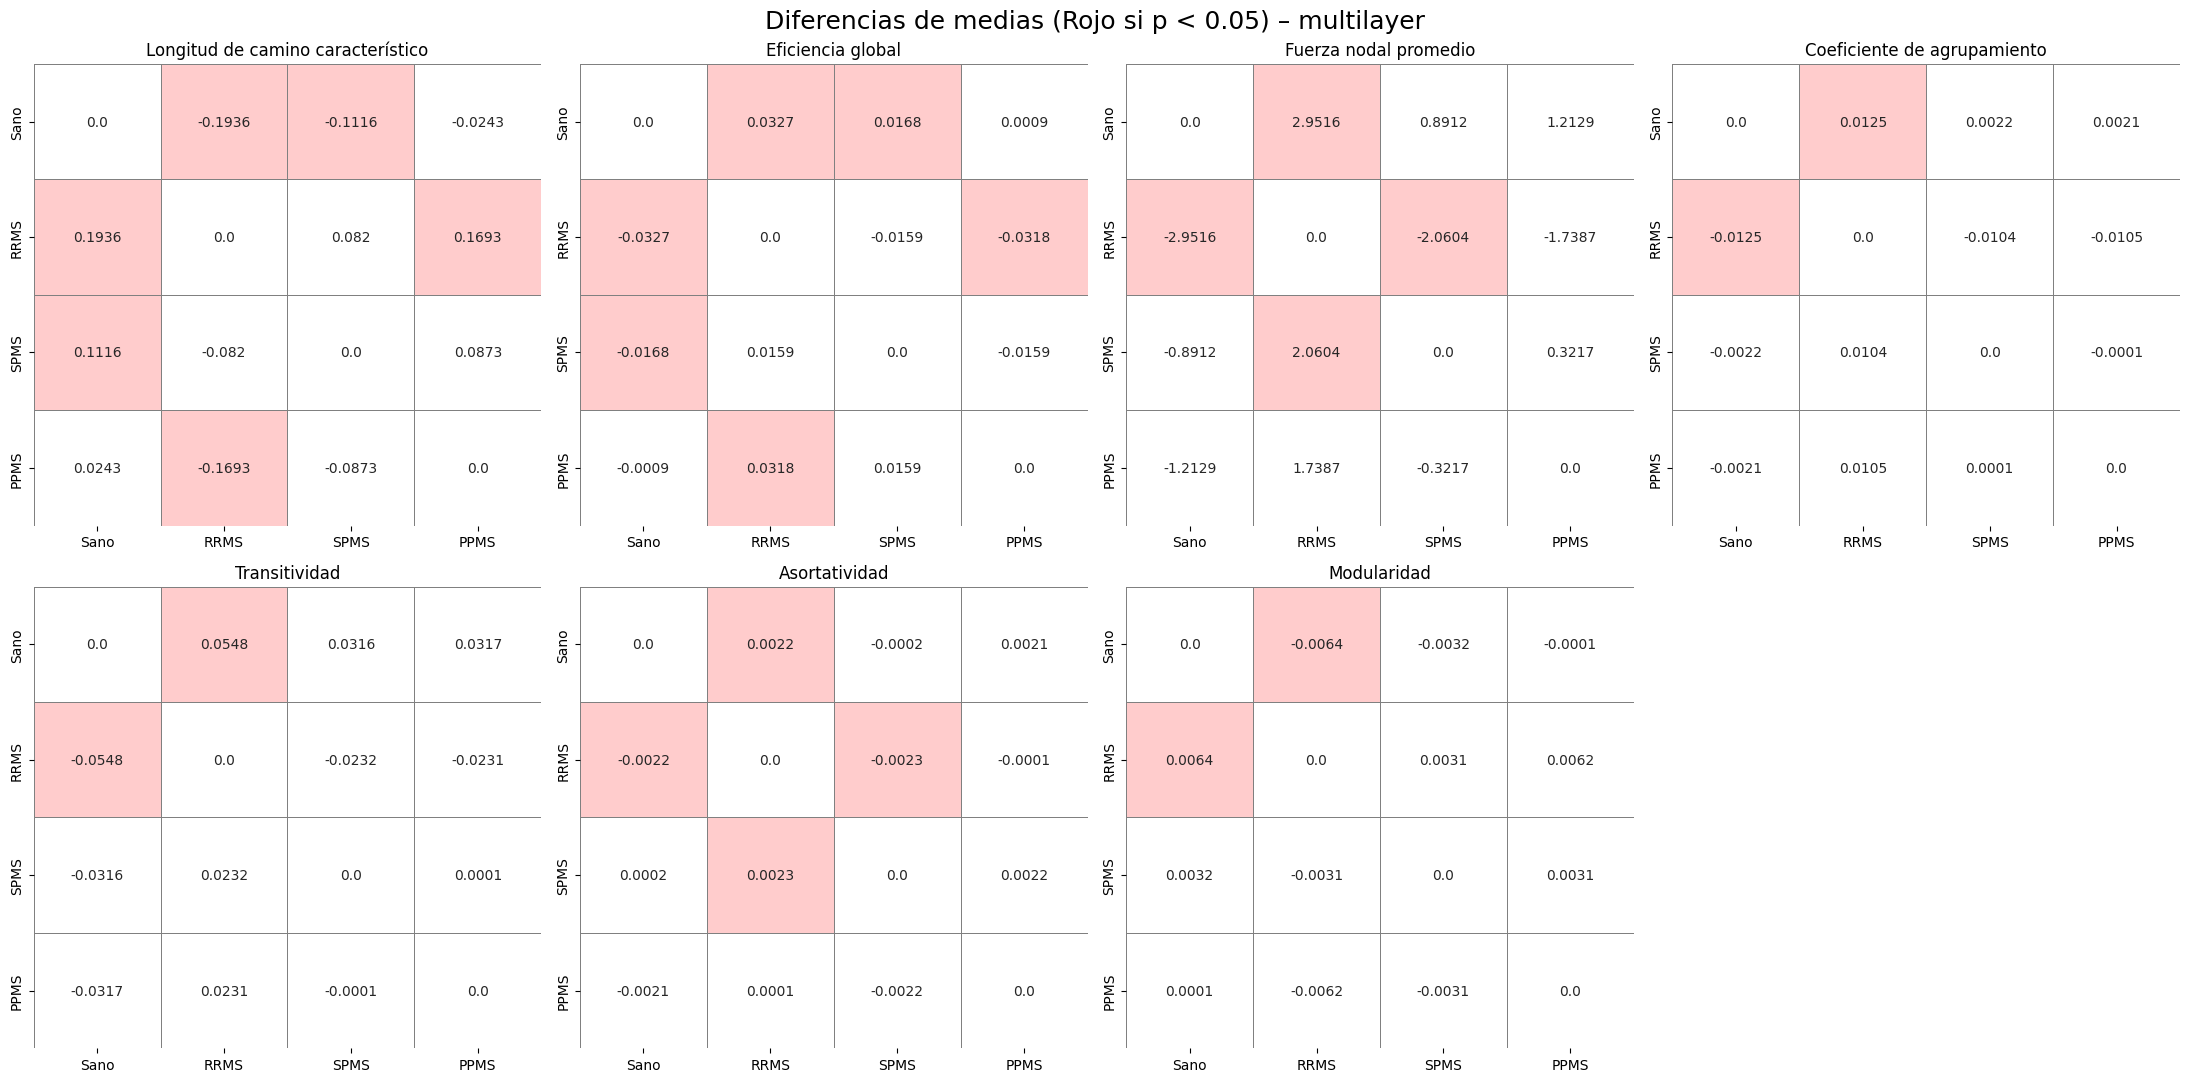

In [12]:
metrica_grafo = ['Longitud de camino característico', 'Eficiencia global',
       'Fuerza nodal promedio', 'Coeficiente de agrupamiento', 'Transitividad',
       'Asortatividad', 'Modularidad']
global_metrics = [multi_global_metrics]

for global_metric_i, global_metric_name in zip(
        global_metrics,
        ["multilayer"]):  # ajusta los nombres si quieres

    # Ejecutar análisis para las 7 métricas del grafo
    results = []
    for metrica_grafo_i in metrica_grafo:
        result = analizar_diferencias_con_pares(global_metric_i, metrica_grafo_i, "mstypes")
        results.append(result)

    # Generar figura 2x4
    plot_all_metrics_for_global(results, metrica_grafo, global_metric_name)